In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
from utils import UtilsKy
from analyzer import HelperAnalyzer, AnalyzerPrediction

In [4]:
# for autoreload modules
%load_ext autoreload
%autoreload 2

In [5]:
# pytorch mlp for binary classification
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_curve, auc
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

In [6]:
def minMaxScaler_own(teach, test):
    teach = teach.copy()
    test = test.copy()
    col_names = list(teach)
    for col in col_names:
        x_min = teach[col].min(axis=0)
        x_max = teach[col].max(axis=0)
        teach[col] = (teach[col] - x_min) / (x_max - x_min)
        test[col] = (test[col] - x_min) / (x_max - x_min)
        test[col] = np.where(test[col] > 1,  1, test[col])
        test[col] = np.where(test[col] < 0 , 0, test[col])        
    return teach, test

In [7]:
db_teach_orig = pd.read_csv( UtilsKy.DB_TEACH_KYW3, dtype=str, encoding='cp1251')

In [8]:
db_test_orig = pd.read_csv(UtilsKy.DB_TEST_KYW3, dtype=str, encoding='cp1251')

In [9]:
white = pd.read_csv(UtilsKy.WHITE_KYW3 , dtype=str)

In [10]:
df = db_teach_orig.copy()
db_test = db_test_orig.copy()

In [11]:
str(list(df))

"['amount', 'amount_deviation', 'bank_currency', 'bin', 'city', 'count_months_to_end_card', 'day_of_week', 'gender2', 'hour', 'id', 'is_city_resolved', 'is_gender_undefined', 'latitude', 'longitude', 'order_id', 'phone_2_norm', 'status']"

In [12]:
df.head()

,amount,amount_deviation,bank_currency,bin,city,count_months_to_end_card,day_of_week,gender2,hour,id,is_city_resolved,is_gender_undefined,latitude,longitude,order_id,phone_2_norm,status
0,1.00,-3,112,547087,Stuttgart,29,3,undefined,09,547087******1680_2022-04,1,1,48.7667,9.1833,49219577955111383,55,0
1,25.00,-2,840,517148,Kapaa,41,3,f,12,517148******7320_2023-04,1,0,22.0837,-159.3553,49221760925063337,08,0
2,21.18,-2,840,546540,undefined,44,3,m,15,546540******9404_2023-07,0,0,38.0000,-97.0000,49224688788195598,40,0
3,200.00,2,840,510805,Oakland,40,3,m,15,510805******1186_2023-03,1,0,37.8116,-122.2420,49224696921328680,10,0
4,2.38,-3,76,544731,Rio De Janeiro,80,3,undefined,15,544731******7316_2026-07,1,1,-22.9000,-43.2333,49224839756465248,19,0


In [13]:
numeric_cols = ['amount', 'bank_currency', 'bin', 'count_months_to_end_card', 'day_of_week', 'is_city_resolved', 'hour',
                'is_gender_undefined', 'latitude', 'longitude', 'phone_2_norm']# 'amount_deviation'

In [14]:
df.status = df.status.astype('float32')
db_test.status = df.status.astype('float32')

In [15]:
geo_cols = ['latitude', 'longitude']
df[geo_cols] = df[geo_cols].apply(pd.to_numeric, errors="coerce")
db_test[geo_cols] = db_test[geo_cols].apply(pd.to_numeric, errors="coerce")

In [16]:
lat_replace = df.latitude.mean()
long_replace = df.longitude.mean()

lat_replace = df.latitude.min()
long_replace = df.longitude.min()

In [17]:
df.latitude = df.latitude.fillna(lat_replace)
df.longitude = df.longitude.fillna(long_replace)
db_test.latitude = db_test.latitude.fillna(lat_replace)
db_test.longitude = db_test.longitude.fillna(long_replace)

In [18]:
df[numeric_cols] = df[numeric_cols].astype('float32').copy()
db_test[numeric_cols] = db_test[numeric_cols].astype('float32').copy()

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [20]:
scaler = 'own'
if scaler != 'own':
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    db_test[numeric_cols] = scaler.fit_transform(db_test[numeric_cols])

In [21]:
if scaler =='own' :
    df[numeric_cols], db_test[numeric_cols] = minMaxScaler_own(df[numeric_cols], db_test[numeric_cols])

In [22]:
feature_names = numeric_cols + ['status']
df = df[feature_names]

In [23]:
# https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, df): # path
        # store the inputs and outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        # ensure input data is floats
        self.X = self.X.astype('float32')
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.05):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

In [24]:
# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(10, 6)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(6, 1)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid()
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        X = self.act3(X)
        return X

In [25]:
# prepare the dataset
def prepare_data(df):
    # load the dataset
    dataset = CSVDataset(df)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

In [26]:
def train_model(train_dl, model, optimizer=None, n_epoch=100, lr=0.01, momentum=0.9):
    criterion = BCELoss()
    if optimizer == None:
        optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)   
    for epoch in range(n_epoch):
        for i, (inputs, targets) in enumerate(train_dl):
            optimizer.zero_grad()
            yhat = model(inputs)
            loss = criterion(yhat, targets)
            loss.backward()
            optimizer.step()

In [27]:
# evaluate the model
def evaluate_model(test_dl, model,threshold=0.015898451):
    predictions, actuals = list(), list()
    pred_proba = list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        #yhat = yhat.round()        
        pred_proba.append(yhat)
        yhat = np.where(yhat > threshold, 1, 0)
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    pred_proba = vstack(pred_proba)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    f1 = f1_score(actuals, predictions)
    logloss = log_loss(actuals, pred_proba)
    fpr, tpr, _ = roc_curve(actuals, pred_proba)
    auc_score = auc(fpr, tpr)
    return acc, f1, logloss, auc_score

In [28]:
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

In [29]:
def get_db_test_prediction(db_test, model, numeric_cols):
    predictions = list()
    test = db_test[numeric_cols].values
    for row in test:
        predictions.append(predict(row, model)[0][0])
    return predictions         

In [30]:
train_dl, test_dl = prepare_data(df)
print(len(train_dl.dataset), len(test_dl.dataset))

411754 21671


In [31]:
# define the network
n_feature = len(numeric_cols)
model = MLP(n_feature)

In [32]:
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

In [33]:
train_model(train_dl, model, optimizer, n_epoch=30, lr=0.01, momentum=0.9)

In [34]:
percent = 0.2
predict_proba = get_db_test_prediction(db_test, model,numeric_cols)
predict_proba_sort = -np.sort(-np.array(predict_proba))
ids = round(len(predict_proba_sort)*percent)
threshold = predict_proba_sort[ids]

In [35]:
# evaluate the model
acc, f1, logloss, auc_score = evaluate_model(test_dl, model,threshold=threshold)
print('Accuracy: %.3f' % acc)
print('f1_score: %.3f' % f1)
print('logloss: %.3f' % logloss)
print('auc: %.3f' % auc_score)

Accuracy: 0.795
f1_score: 0.048
logloss: 0.072
auc: 0.631


In [36]:
analyzer_prediction =  AnalyzerPrediction(db_teach_orig, db_test_orig, white)

In [37]:
result_df_amount = None

In [38]:
n_epoch = 30
lr = 0.01 
momentum = 0.9
for n_epoch in [30]:
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
    train_model(train_dl, model, optimizer, n_epoch=n_epoch, lr=lr, momentum=momentum)
    
    test_probability = get_db_test_prediction(db_test, model, numeric_cols)
    db_test_orig["probability"] = test_probability
        
    description = '-' . join([str(elem) for elem in (n_epoch, momentum, lr)])       
    result_df_amount = analyzer_prediction.get_table_prediction(description=description, result_df=result_df_amount, metric="amount")
    print( 'n_epoch={}'. format(n_epoch ))

n_epoch=30


In [39]:
n = result_df_amount.shape[0]
sub_rows = list(range(n))[::2]
stat_best = result_df_amount.copy().iloc[sub_rows,:]

col_names = [col for col in stat_best.columns if col.startswith('p_') ] 
stat_best.loc[:, col_names] = stat_best.loc[:, col_names].astype(float)
stat_best = stat_best.sort_values(by="rating", ascending=False)

In [40]:
stat_best.iloc[:,:15]

,description,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_10,p_20,rating,n_white_list,n_test_in_wl,n_test_bad_in_wl,amount_test_in_wl
0,30-0.9-0.01,4.11,6.58,9.03,12.29,15.59,16.9,20.86,29.63,50.02,127.25,1019125,22992,34,1640236.53


In [334]:
stat_best.iloc[:,:15]

,description,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_10,p_20,rating,n_white_list,n_test_in_wl,n_test_bad_in_wl,amount_test_in_wl
16,10-6-1 -amount n_ep=30,5.89,15.65,20.82,23.69,25.93,29.12,30.40,37.91,54.58,184.47,1019125,22992,34,1640236.53
12,10-6-1 -amount n_ep=30,4.78,14.84,18.70,24.61,25.97,28.48,31.40,38.67,55.01,182.58,1019125,22992,34,1640236.53
20,10-6-1 -amount n_ep=31,6.62,13.98,18.34,21.81,26.84,28.83,32.03,38.63,54.25,180.47,1019125,22992,34,1640236.53
26,10-6-1 -amount n_ep=28,10.23,14.86,19.78,23.63,25.18,25.82,27.34,33.78,52.77,180.23,1019125,22992,34,1640236.53
18,10-6-1 -amount n_ep=35,10.05,14.38,16.75,21.73,27.57,29.72,31.98,38.29,51.34,180.11,1019125,22992,34,1640236.53
28,10-6-1 -amount n_ep=29,10.35,16.28,18.33,20.19,24.01,26.89,29.16,33.87,54.63,177.66,1019125,22992,34,1640236.53
10,10-6-1 -amount n_ep=25,5.46,12.04,18.64,20.72,24.18,28.77,30.60,37.30,56.40,174.74,1019125,22992,34,1640236.53
8,10-6-1 -amount n_ep=18,6.25,11.81,16.17,18.70,21.68,27.56,30.22,42.10,56.61,173.32,1019125,22992,34,1640236.53
14,10-6-1 -amount n_ep=28,6.74,12.52,19.04,21.67,24.82,27.16,29.20,37.02,50.72,172.53,1019125,22992,34,1640236.53
24,10-6-1 -amount n_ep=33,8.44,15.84,18.41,18.80,22.49,24.04,27.72,33.16,49.29,166.43,1019125,22992,34,1640236.53


## Deep Explainer

In [41]:
# https://www.kaggle.com/ceshine/feature-importance-from-a-pytorch-model
import shap
import torch

In [42]:
DEVICE = "cpu"

In [44]:
x_train = df[numeric_cols].copy().astype(np.float32)
x_test = db_test[numeric_cols].copy().astype(np.float32)

In [45]:
x_train = x_train.values
x_test = x_test.values

In [46]:
%%time
e = shap.DeepExplainer(
        model, 
        torch.from_numpy(
            x_train[np.random.choice(np.arange(len(x_train)), 10000, replace=False)]
        ).to(DEVICE))

CPU times: user 14 ms, sys: 69 µs, total: 14.1 ms
Wall time: 12.1 ms


In [47]:
%%time
x_samples = x_test[np.random.choice(np.arange(len(x_test)), 300, replace=False)]
print(len(x_samples))
shap_values = e.shap_values(
    torch.from_numpy(x_samples).to(DEVICE)
)

300
CPU times: user 3min 50s, sys: 1min 18s, total: 5min 9s
Wall time: 1min 53s


In [48]:
shap_values.shape

(300, 11)

In [49]:
import pandas as pd
df_impotrance = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0), 
    "stdev_abs_shap": np.std(np.abs(shap_values), axis=0), 
    "name": numeric_cols
})
df_impotrance.sort_values("mean_abs_shap", ascending=False)[:18]

,mean_abs_shap,stdev_abs_shap,name
0,0.004686,0.004906,amount
6,0.002635,0.002134,hour
3,0.002079,0.001404,count_months_to_end_card
7,0.001993,0.001982,is_gender_undefined
5,0.001892,0.001198,is_city_resolved
10,0.001550,0.001328,phone_2_norm
2,0.001379,0.001393,bin
1,0.001233,0.002366,bank_currency
4,0.000702,0.000702,day_of_week
8,0.000246,0.000456,latitude


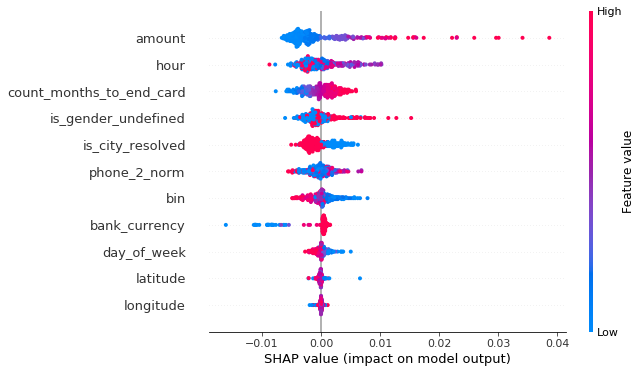

In [50]:
shap.summary_plot(shap_values, features=x_samples, feature_names=numeric_cols)

In [51]:
# https://colab.research.google.com/github/ray-project/tutorial/blob/master/tune_exercises/exercise_2_optimize.ipynb#scrollTo=LFi0rXSIDJKA
import ray
from ray import tune
from ray.tune import track
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.examples.mnist_pytorch import train, test, ConvNet, get_data_loaders

In [52]:
n_feature = len(numeric_cols)
feature_names = numeric_cols + ['status'] 

In [54]:
ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)

2021-01-21 13:49:35,687	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.105',
 'raylet_ip_address': '192.168.0.105',
 'redis_address': '192.168.0.105:6379',
 'object_store_address': '/tmp/ray/session_2021-01-21_13-49-35_139762_51591/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-21_13-49-35_139762_51591/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-01-21_13-49-35_139762_51591',
 'metrics_export_port': 58791,
 'node_id': 'fc72fedaaa4c5f3a7d4a71b2d06d047f28ed57d0'}

In [55]:
n_feature = len(numeric_cols)
def train_m(config):
    model = MLP(n_feature)
    train_loader, test_loader = prepare_data(df[feature_names])
    optimizer = SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train_model(train_loader, model, optimizer, n_epoch=20)
        acc, _, _, auc_score = evaluate_model(test_loader, model)
        tune.track.log(mean_accuracy=auc_score)

In [56]:
search_space = {
    "lr": tune.grid_search([0.001, 0.01, 0.1, 0.2]),
    "momentum": tune.uniform(0.1, 0.9)
}
analysis = tune.run(
    train_m,
    verbose=0,
    config=search_space#{"lr": tune.grid_search([0.001, 0.01, 0.1])}
)

2021-01-21 13:50:46,160	WARNING function_runner.py:540 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-01-21 13:50:46,693	WARNING worker.py:1034 -- Warning: The actor ImplicitFunc has size 39883284 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("ggplot")

Text(0, 0.5, 'Test AUC')

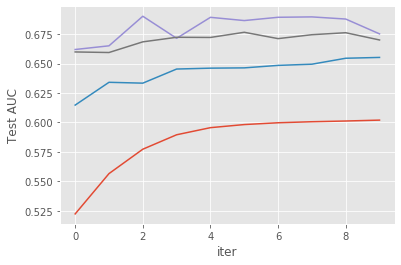

In [58]:
dfs = analysis.fetch_trial_dataframes()
[d.mean_accuracy.plot() for d in dfs.values()]
plt.xlabel("iter"); plt.ylabel("Test AUC")

In [59]:
df_res = analysis.results_df
df_res[['training_iteration', 'mean_accuracy', 'config.lr', 'config.momentum']]

,training_iteration,mean_accuracy,config.lr,config.momentum
trial_id,,,,
e5eb6_00000,10,0.601979,0.001,0.433618
e5eb6_00001,10,0.655266,0.010,0.676260
e5eb6_00002,10,0.675275,0.100,0.100091
e5eb6_00003,10,0.670098,0.200,0.341866
